## Raster Data Access with Scenes 
### [scenes.search](https://docs.descarteslabs.com/descarteslabs/scenes/docs/search.html) 
Returns a [SceneCollection](https://docs.descarteslabs.com/descarteslabs/scenes/docs/scenecollection.html) object, a collection of metadata associated with images that match our query and [GeoContext](https://docs.descarteslabs.com/descarteslabs/scenes/docs/geocontext.html) which has metadata about the region of interest, projections, and scale.
### [scenes.ndarray](https://docs.descarteslabs.com/descarteslabs/scenes/docs/scene.html#descarteslabs.scenes.scene.Scene.ndarray)

In [2]:
# keep logging quiet
import logging
logging.getLogger().setLevel(logging.INFO)
logging.captureWarnings(True)
# import packages
import descarteslabs as dl
import numpy as np

In [5]:
#Searching area of interest Folsom Lake, Northern California using polygon
feature = {
    "type":"Feature",
    "geometry":{
    "type":"Polygon",
        "coordinates":[[
            [-121.18599701346828, 38.693120375759946],
            [-121.08821867639196, 38.693120375759946],
            [-121.08821867639196, 38.77282238770522],
            [-121.18599701346828, 38.77282238770522],
            [-121.18599701346828, 38.693120375759946]
        ]]
    },
    "properties": {}
} 
fc = {"type": "FeatureCollection", "features": [feature], "properties": {}}

from ipyleaflet import Map, GeoJSON
m = Map(center=(38.733120, -121.1221), zoom=12)
m.add_layer(GeoJSON(data=fc))
m

Map(center=[38.73312, -121.1221], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', …

In [10]:
scenes, ctx = dl.scenes.search(
    aoi=feature,
    products='sentinel-2:L1C',
    start_datetime='2019-07-31',
    end_datetime='2019-08-05'
)
scenes

SceneCollection of 2 scenes
  * Dates: Aug 03, 2019 to Aug 03, 2019
  * Products: sentinel-2:L1C: 2

In [11]:
ctx

AOI(geometry=<shapely.geom...x7f2f17614c50>,
    resolution=10.0,
    crs='EPSG:32610',
    align_pixels=True,
    bounds=(-121.18599701346828, 38.693120375759946, -121.08821867639196, 38.77282238770522),
    bounds_crs='EPSG:4326',
    shape=None)

In [14]:
scenes[0]
scenes[0].properties.date #Acessing individual properties

datetime.datetime(2019, 8, 3, 19, 3, 59, 316807)

In [15]:
ctx = ctx.assign(resolution=10)
a = scenes[0].ndarray(
    bands='red green blue',
    ctx=ctx
)
a.shape

(3, 903, 833)

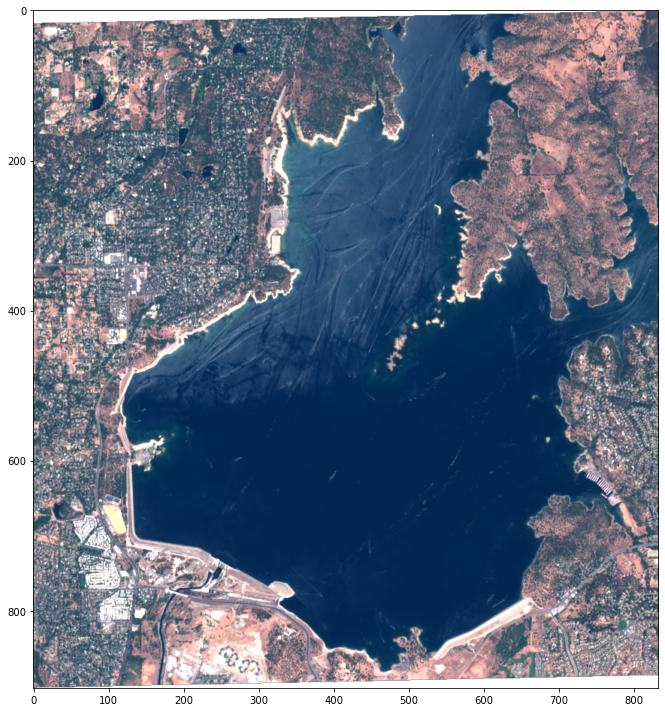

In [16]:
%matplotlib inline
dl.scenes.display(a)

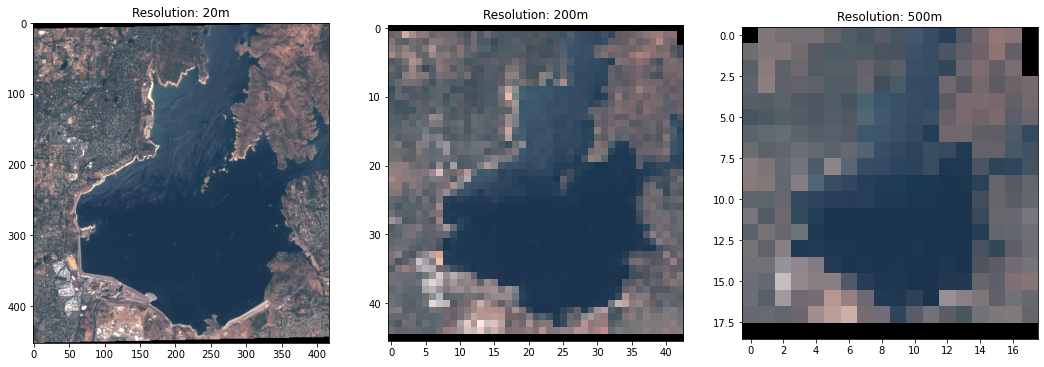

In [17]:
import matplotlib.pyplot as plt
arrays = []
resolution = [20, 200, 500]
for res in resolution:
    # assignment yields a new geocontext with the modified property
    ctx = ctx.assign(resolution=res)
    a = scenes[0].ndarray(
        bands='red green blue',
        ctx=ctx,
        bands_axis=-1,
        scaling=[(0, 2500)] * 3
    )
    arrays.append(a)
    
fig, ax = plt.subplots(1, 3, figsize=(18, 10))
for i in range(3):
    ax[i].imshow(arrays[i])
    ax[i].set_title('Resolution: {}m'.format(resolution[i]))

In [18]:
# print available bands for this scene:
scenes[0].properties.bands.keys()

dict_keys(['derived:bai', 'derived:evi', 'derived:ndvi', 'derived:ndwi', 'derived:ndwi1', 'derived:ndwi2', 'derived:rsqrt', 'derived:visual_cloud_mask', 'alpha', 'blue', 'bright-mask', 'cirrus', 'cirrus-cloud-mask', 'cloud-mask', 'coastal-aerosol', 'green', 'nir', 'opaque-cloud-mask', 'red', 'red-edge', 'red-edge-2', 'red-edge-3', 'red-edge-4', 'swir1', 'swir2', 'water-vapor'])

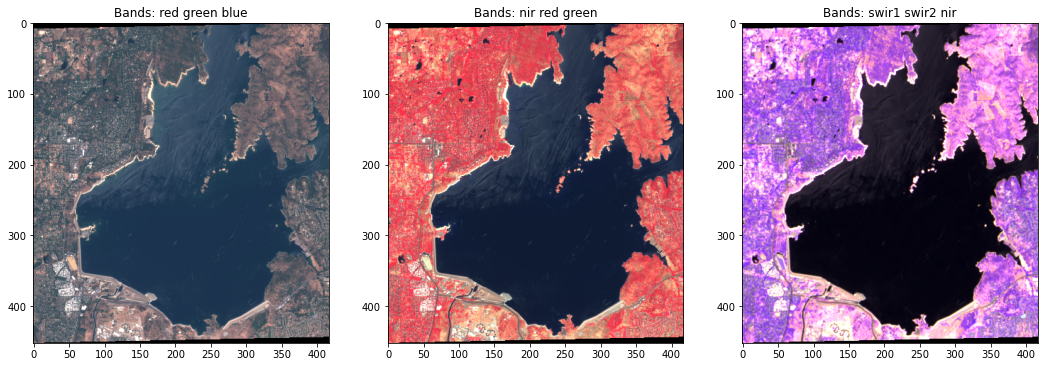

In [19]:
arrays = []
ctx = ctx.assign(resolution=20)
bands = ['red green blue', 'nir red green', 'swir1 swir2 nir']
for b in bands:
    a = scenes[0].ndarray(
        bands=b,
        ctx=ctx,
        bands_axis=-1,
        scaling=[(0, 2500)] * 3
    )
    arrays.append(a)
    
fig, ax = plt.subplots(1, 3, figsize=(18, 10))
for i in range(3):
    ax[i].set_title('Bands: {}'.format(bands[i]))
    ax[i].imshow(arrays[i])

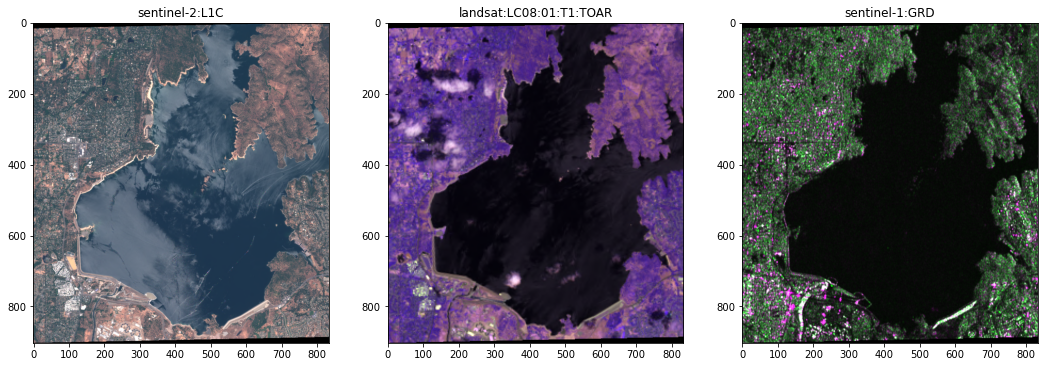

In [20]:
fig, ax = plt.subplots(1, 3, figsize=(18, 10))
products = ['sentinel-2:L1C', 'landsat:LC08:01:T1:TOAR', 'sentinel-1:GRD']
bands = ['red green blue', 'swir1 swir2 nir', 'vv vh vv']
scaling = [[(0, 2500)] * 3, [(0, 5000)] * 3, None]
for i in range(3):
    s, ctx = dl.scenes.search(feature, products[i], start_datetime='2018-06-01', end_datetime='2018-06-30')
    ctx = ctx.assign(resolution=10)
    ax[i].imshow(s.mosaic(bands=bands[i], ctx=ctx, bands_axis=-1, scaling=scaling[i]))
    ax[i].set_title(products[i])

# Data Management with Catalog

`Product.search()` is the entry point for searching products. It returns a query builder that you can use to refine your search and can iterate over to retrieve search results.

In [31]:
from descarteslabs.catalog import Image, properties as p
geometry = {
     "type": "Polygon",
     "coordinates": [[
         [2.915496826171875, 42.044193618165224],
         [2.838592529296875, 41.92475971933975],
         [3.043212890625, 41.929868314485795],
         [2.915496826171875, 42.044193618165224]
     ]]
 }

search = Product.get("landsat:LC08:01:RT:TOAR").images()
search = search.intersects(geometry)
search = search.filter((p.acquired > "2017-01-01") & (p.acquired < "2018-01-01"))
search = search.filter(p.cloud_fraction < 0.2)
search.count()

7

In [34]:
# Search for image summaries, bucketed by time intervals with summary_interval()
from descarteslabs.catalog import Image, properties as p
search = Image.search().filter(p.product_id == "landsat:LC08:01:T1:TOAR")
search.summary()
search.summary_interval(interval="month", start_datetime="2017-01-01", end_datetime="2017-06-01")

[
 Summary for 9872 images:
  - Total bytes: 1,230,379,744,242
  - Interval start: 2017-01-01 00:00:00+00:00,
 
 Summary for 10185 images:
  - Total bytes: 1,288,400,404,886
  - Interval start: 2017-02-01 00:00:00+00:00,
 
 Summary for 12426 images:
  - Total bytes: 1,556,107,514,684
  - Interval start: 2017-03-01 00:00:00+00:00,
 
 Summary for 12492 images:
  - Total bytes: 1,476,030,969,986
  - Interval start: 2017-04-01 00:00:00+00:00,
 
 Summary for 13768 images:
  - Total bytes: 1,571,780,442,608
  - Interval start: 2017-05-01 00:00:00+00:00]

# Scalable Compute with Tasks
[Tasks](https://docs.descarteslabs.com/guides/tasks.html) is an interface to interact with Tasks service that provides a solution for large-scale computation 

[1] [Tasks Documentation](https://docs.descarteslabs.com/descarteslabs/client/services/tasks/readme.html)

[2] [Tasks Guide](https://docs.descarteslabs.com/guides/tasks.html)

In [35]:
def get_image(dltile_key):
    tile = dl.scenes.DLTile.from_key(dltile_key)
    sc, ctx = dl.scenes.search(aoi=tile, products='usda:naip:rgbn:v1', start_datetime='2015-01-01', end_datetime='2016-01-01')
    im = sc.mosaic(bands='red green blue nir', ctx=ctx)
    return im

def vegetation_mask(im):
    n = im[-1].astype(float)
    r = im[0].astype(float)
    NDVI = (n - r) / (n + r + 1e-8)
    return NDVI

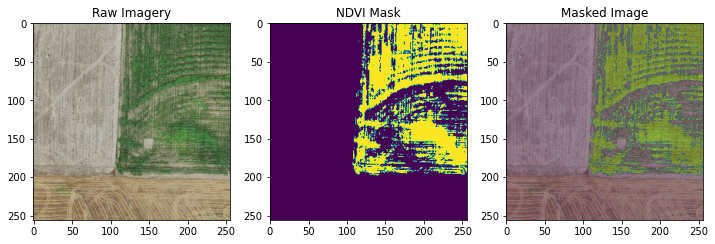

In [36]:
lon, lat = -99.35249805450438,39.38670997057946
tile = dl.scenes.DLTile.from_latlon(lat=lat, lon=lon, resolution=1, tilesize=256, pad=0)

im = get_image(tile.key)
veg_mask = vegetation_mask(im)

fig, ax = plt.subplots(1, 3, figsize=(12, 5))
ax[0].imshow(np.moveaxis(im[0:3], 0, -1))
ax[1].imshow(veg_mask > 0.3)
ax[2].imshow(np.moveaxis(im[0:3], 0, -1))
ax[2].imshow(veg_mask > 0.3, alpha=0.3, clim=(0, 1))
ax[0].set_title('Raw Imagery')
ax[1].set_title('NDVI Mask')
ax[2].set_title('Masked Image')
pass

### [tasks.create_function](https://docs.descarteslabs.com/descarteslabs/client/services/tasks/readme.html#descarteslabs.client.services.tasks.Tasks.create_function) to create a task group
To deploy our vegetation model over a larger region, make a new Task group using the [create_function](https://docs.descarteslabs.com/descarteslabs/client/services/tasks/readme.html#descarteslabs.client.services.tasks.Tasks.create_function) method. The method will serialize our local code and put it into a Docker container for execution. Descartes Labs provides publicaly available images with many of the geospatial and scientific Python packages preinstalled. They can be found [here](https://docs.descarteslabs.com/guides/tasks.html). The status of the Tasks group can be found on the [Monitor](https://monitor.descarteslabs.com/) page.

In [37]:
def vegetation_percentage(dltile_key):
    im = get_image(dltile_key)
    mask = vegetation_mask(im)
    return round(np.sum((mask > 0.3) == 1) / (mask.shape[0] * mask.shape[1]), 5)

vegetation_percentage(tile.key)

0.24399

In [38]:
# Python 3.7
docker_image = 'us.gcr.io/dl-ci-cd/images/tasks/public/py3.7:v2020.01.21-7-g309186be'

tasks = dl.Tasks()
async_func = tasks.create_function(
    f=vegetation_percentage,
    name='vegetation-demo',
    image=docker_image,
    maximum_concurrency=10,
)

### Launching Tasks
Task group instantiated. It returned a [CloudFunction](https://docs.descarteslabs.com/descarteslabs/client/services/tasks/readme.html#descarteslabs.client.services.tasks.CloudFunction) which can be used to send our requests to the Task group. Tasks are then put into a queue and scheduled for work.

In [40]:
async_func
aoi = {"type":"Feature","geometry":{"type":"Polygon","coordinates":[[[-99.32275771466082,39.510715877324],[-99.17530059814455,39.510715877324],[-99.17530059814455,39.537992699478735],[-99.32275771466082,39.537992699478735],[-99.32275771466082,39.510715877324]]]}, "properties":{}}
from ipyleaflet import Map, GeoJSON, basemaps
m = Map(center=(39.52371, -99.25272), zoom=13, basemap=basemaps.Esri.WorldImagery)
m.add_layer(GeoJSON(data=aoi))
m

Map(center=[39.52371, -99.25272], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', …

In [41]:
# break region up into chuncks which can be analyzed in parallel
tiles = dl.scenes.DLTile.from_shape(aoi, resolution=1, tilesize=512, pad=0)
len(tiles)

182

In [42]:
#There are 182 tiles in this region of interest. We can easily launch our tasks by iterating over the tiles and calling the CloudFunction object as if we were calling a local function.
for tile in tiles:
    async_func(tile.key)

### Getting Results
Retreive task groups using [tasks.get_group_by_name](https://docs.descarteslabs.com/descarteslabs/scenes/docs/geocontext.html#descarteslabs.scenes.geocontext.DLTile).
Get results back using [tasks.get_task_results](https://docs.descarteslabs.com/descarteslabs/client/services/tasks/readme.html#descarteslabs.client.services.tasks.Tasks.get_task_results).

In [43]:
group_info = tasks.get_group_by_name('vegetation-demo')
group_info.id

'84a2cb0b'

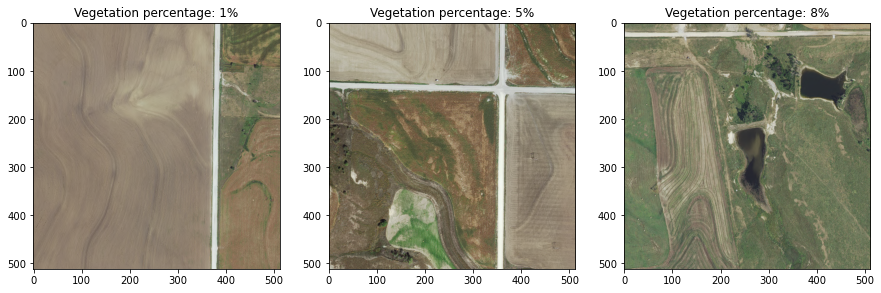

In [45]:
#retrieve metadata for each task
results = tasks.get_task_results(group_info.id, include=['arguments', 'result_url'])
results['results']

#load the results
import json
import requests

result_dict = {}
for result in results['results']:
    if result.status == 'SUCCESS':
        r = json.loads(requests.get(result.result_url).text)
        args_dict = json.loads(result.arguments)
        key = args_dict['args'][0]
        result_dict[key] = r
        
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

for i, key in enumerate(result_dict):
    im = get_image(key)
    p = result_dict[key]
    ax[i].imshow(np.moveaxis(im[0:3], 0, -1))
    ax[i].set_title(f'Vegetation percentage: {round(p * 100)}%')
    
    if i >= 2:
        break

In [46]:
tasks.delete_group_by_id(group_info.id)

{
  'ack_deadline': 300,
  'build_log_size_bytes': None,
  'cpu': 1,
  'created': '2020-11-10T09:30:55.722210',
  'function_python_version': '3.7.8',
  'function_type': 'py_pickle',
  'gpu': 0,
  'id': '84a2cb0b',
  'image': 'us.gcr.io/dl-ci-cd/images/tasks/public/py3.7:v2020.01.21-7-g309186be',
  'labels': {},
  'maximum_concurrency': 10,
  'mem': 2147483648,
  'minimum_concurrency': None,
  'minimum_seconds': None,
  'name': 'vegetation-demo',
  'queue': {
    'failures': 0,
    'pending': 0,
    'successes': 182
  },
  'status': 'terminated',
  'updated': '2020-11-10T09:46:33.811778',
  'upload_url': None,
  'worker_timeout': 1800,
  'workers': {
    'failed': 9,
    'pending': 0,
    'running': 0,
    'succeeded': 0,
    'unknown': 0
  }
}

# Interactive Computing with Workflows

In [48]:
import descarteslabs.workflows as wf
s2_collection = wf.ImageCollection.from_id("sentinel-2:L1C", start_datetime='2019-12-10', end_datetime='2019-12-16')
s2_collection
s2_image = s2_collection.min(axis='images')
s2_image


Job ID: 01347731c372691e25ac5175ac3b7785962299345b6a65c2
[######] | Steps: 74/74 | Stage: SUCCEEDED                                    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


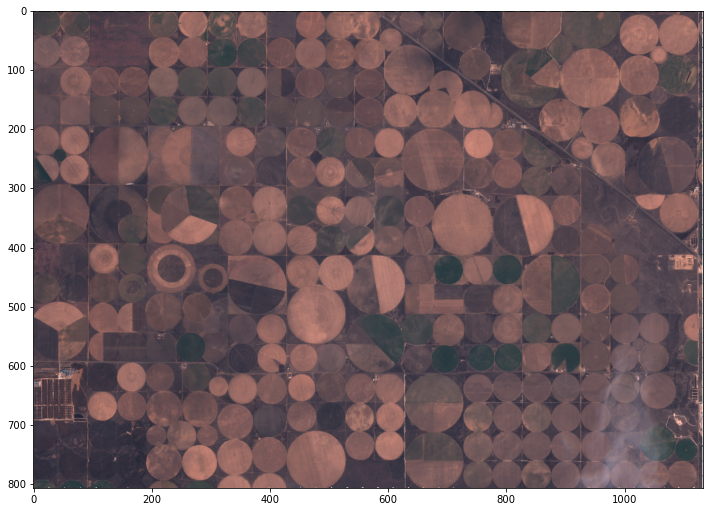

In [49]:
geometry = wf.Geometry.from_geojson({
        "type": "Polygon",
        "coordinates": [
          [
            [
              -102.78739929199219,
              36.0513195750255
            ],
            [
              -102.58415222167969,
              36.0513195750255
            ],
            [
              -102.58415222167969,
              36.16836821871061
            ],
            [
              -102.78739929199219,
              36.16836821871061
            ],
            [
              -102.78739929199219,
              36.0513195750255
            ]
          ]
        ]
      })
geoctx = wf.GeoContext(geometry=geometry, crs='EPSG:3857', resolution=20.0)
image_result = s2_image.pick_bands("red green blue").scale_values(0, 1, 0.0, 0.4).compute(geoctx=geoctx)
import matplotlib.pyplot as plt
plt.figure(figsize=[12,12])
plt.imshow(image_result.ndarray.transpose((1,2,0)))

In [55]:
#Tile based visualizations
layer = s2_image.pick_bands("red green blue").visualize("rgb layer", scales=[[0,0.4], [0,0.4], [0,0.4]])
wf.map


`ipyleaflet` and/or `ipywidgets` Jupyter extensions are not installed! (or you're not in a Jupyter notebook.)
To install for JupyterLab, run this in a cell:
    !jupyter labextension install jupyter-leaflet @jupyter-widgets/jupyterlab-manager
To install for plain Jupyter Notebook, run this in a cell:
    !jupyter nbextension enable --py --sys-prefix ipyleaflet
Then, restart the kernel and refresh the webpage.


In [51]:
#Derived quantities
nir_image, red_image = s2_image.unpack_bands("nir red")
ndvi_image = (nir_image - red_image) / (nir_image + red_image)
ndvi_image

In [56]:
wf.map.center = [36.05, -102.78]
red_image.visualize("Red", scales=[0., 1.], colormap='Reds')
nir_image.visualize("NIR", scales=[0., 1.], colormap='Greens')
ndvi_image.visualize("NDVI", scales=[0., 1.], colormap='viridis')
wf.map


`ipyleaflet` and/or `ipywidgets` Jupyter extensions are not installed! (or you're not in a Jupyter notebook.)
To install for JupyterLab, run this in a cell:
    !jupyter labextension install jupyter-leaflet @jupyter-widgets/jupyterlab-manager
To install for plain Jupyter Notebook, run this in a cell:
    !jupyter nbextension enable --py --sys-prefix ipyleaflet
Then, restart the kernel and refresh the webpage.


In [57]:
ndvi_threshold_param = wf.parameter("ndvi_threshold", wf.Float)
ndvi_threshold_param

In [59]:
is_growing = ndvi_image > ndvi_threshold_param
layer = is_growing.visualize("growing", scales=[0, 1], colormap='magma', ndvi_threshold=0.3)
layer

In [60]:
wf.map


`ipyleaflet` and/or `ipywidgets` Jupyter extensions are not installed! (or you're not in a Jupyter notebook.)
To install for JupyterLab, run this in a cell:
    !jupyter labextension install jupyter-leaflet @jupyter-widgets/jupyterlab-manager
To install for plain Jupyter Notebook, run this in a cell:
    !jupyter nbextension enable --py --sys-prefix ipyleaflet
Then, restart the kernel and refresh the webpage.
